# $\Phi$-SO demo

## Packages import

In [1]:
# conda env
try:
    get_ipython().system('echo $CONDA_PREFIX')
except:
    pass

/opt/homebrew/Caskroom/miniforge/base/envs/PhySO


In [2]:
try:
    %matplotlib inline
    #get_ipython().run_line_magic('matplotlib', 'inline')
except:
    pass

In [3]:
# External packages
import torch
import numpy as np
import pandas as pd
import time
# Pyplot
import matplotlib.pyplot as plt

# Internal code import
import physo
from physo.learn import monitoring
from physo.task  import benchmark

In [4]:
# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print(DEVICE)

cpu


In [5]:
torch.cuda.is_available()

False

## Test case

#### Target function and wrapper

In [6]:
H0    = 1.0723 #73.3 #1.0723 # #km/s/Mpc
Omega = 1.315 #0.315 #1.315 # 
c     = 1.13 #1.13 # 3e5 # km/s

#H0    = 73.3 #1.0723 # #km/s/Mpc
#Omega = 0.315 #1.315 # 
#c     = 3e5 # km/s

H0    = torch.tensor(np.array(H0)).to(DEVICE)
Omega = torch.tensor(np.array(Omega)).to(DEVICE)
c     = torch.tensor(np.array(c)).to(DEVICE)


f_LCDM = lambda X: (H0**2)*(Omega*(X[0])**3 + 1 - Omega) # (H0**2)*Omega*x**3 + (H0**2)*(1 - Omega) # = c0*x**3 + c1

target_program_str = ["mul", "n2", "H0", "sub", "add", "mul", "Omega", "mul", "x", "n2", "x", "1", "Omega"]
print(len(target_program_str))

13


In [7]:
def wrapper_func (func, X):
    z = X[0]
    def H_func (z):
        X_modif = torch.stack((z+1.,), dim=0)
        res = torch.sqrt(func(X_modif))
        return res  # in Mpc
    integrand = lambda zp: 1/H_func(zp)
    y_primitive = torch.cumulative_trapezoid(y=integrand(z), x=z)
    integral = torch.cat((torch.tensor([y_primitive[0]]), y_primitive))
    #integral  = torch.stack(my_ugly_trapz_cumsum(integrand, z))
    dL = (1+z)*integral # in Mpc
    #mu_z = 5*torch.log10(dL*c)-5*torch.log10(torch.tensor(1e-5)) # 10 pc = 1e-5 Mpc
    mu_z = 5*torch.log10(dL)+5*torch.log10(c)-5*torch.log10(torch.tensor(1e-5)) # 10 pc = 1e-5 Mpc
    return mu_z

#### Observational data

In [8]:
df = pd.read_csv("Scolnic_2018.txt", sep=" ", index_col=False)
df = df.sort_values(by="zcmb")

In [9]:
z_array  = df["zcmb"].to_numpy()
mb_scale = +0.5 #19.253 # https://iopscience.iop.org/article/10.3847/2041-8213/ac5c5b
mu_array = df["mb"] + mb_scale

X_array = np.stack((z_array,), axis=0)
y_array = mu_array

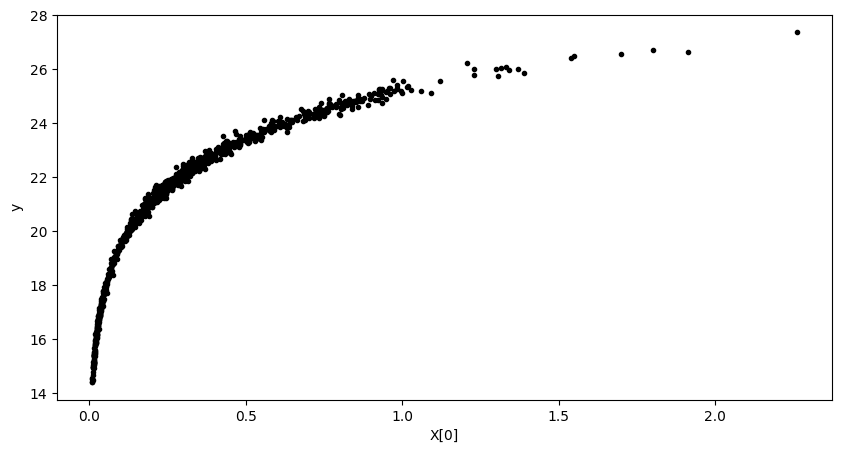

In [10]:
n_dim = X_array.shape[0]
fig, ax = plt.subplots(n_dim, 1, figsize=(10,5))
for i in range (n_dim):
    curr_ax = ax if n_dim==1 else ax[i]
    curr_ax.plot(X_array[i], y_array, 'k.',)
    curr_ax.set_xlabel("X[%i]"%(i))
    curr_ax.set_ylabel("y")
plt.show()

In [11]:
# ------ Vectors ------
# Stack of all input variables
X = torch.tensor(X_array).to(DEVICE)
# Output of symbolic function to guess
y = torch.tensor(y_array).to(DEVICE)

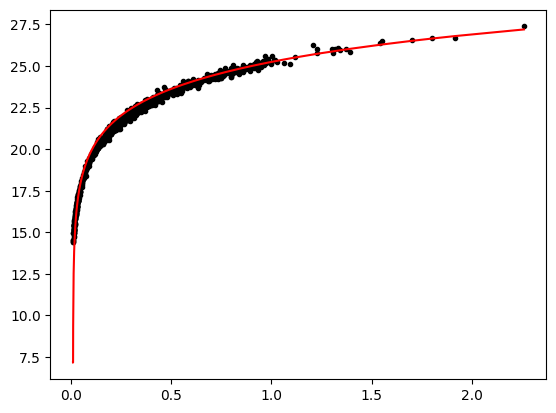

In [12]:
plt.plot(X[0], y, "k.", label="Scolnic_2018")
plt.plot(X[0], wrapper_func(f_LCDM, X), "r-", label="LCDM")

#### Synthetic data

In [13]:
#z_array  = np.linspace(0.01, 2.5, 1000)
#X_array  = np.stack((z_array,), axis=0)

In [14]:
#t0 = time.perf_counter()
#N = 1000
#for _ in range(N):
#    # Output of symbolic function to guess
#    y = wrapper_func(f_LCDM, X).to(DEVICE)
#t1 = time.perf_counter()
#print((t1-t0)/N)

In [15]:
## ------ Vectors ------
## Stack of all input variables
#X = torch.tensor(X_array).to(DEVICE)
#y = wrapper_func(f_LCDM, X).to(DEVICE)
#y += (torch.rand_like(y) - 0.5)*0.5



In [16]:
#plt.plot(X[0], y, "k.", label="Synthetic LCDM")
#plt.plot(X[0], wrapper_func(f_LCDM, X), "r-", label="LCDM")

#### Constants

In [17]:
# ------ Constants ------
const1 = torch.tensor(np.array(1.)).to(DEVICE)

## Run config

### Library config

In [18]:
args_make_tokens = {
                # operations
                "op_names"             : ["mul", "add", "sub", "div", "inv", "n2", "sqrt",], # "exp", "log", "sin", "cos"],
                "use_protected_ops"    : True,
                # input variables
                "input_var_ids"        : {"x" : 0         ,},
                "input_var_units"      : {"x" : [0, 0, 0] ,},
                "input_var_complexity" : {"x" : 1.        ,},
                # constants
                "constants"            : {"1" : const1    , },
                "constants_units"      : {"1" : [0, 0, 0] , },
                "constants_complexity" : {"1" : 1.        , },
                # free constants
                "free_constants"            : {"H0"              , "Omega"              ,},
                "free_constants_init_val"   : {"H0" : 1.         , "Omega" : 1.         ,},
                "free_constants_units"      : {"H0" : [0, -1, 0] , "Omega" : [0, 0, 0]  ,},
                "free_constants_complexity" : {"H0" : 1.         , "Omega" : 1.         ,},
                    }

library_config = {"args_make_tokens"  : args_make_tokens,
                  "superparent_units" : [0, -1, 0],
                  "superparent_name"  : "sqrtH",
                }

### Free constant optimizer config

In [19]:
free_const_opti_args = {
            'loss'   : "MSE",
            'method' : 'LBFGS',
            'method_args': {
                        'n_steps' : 50,
                        'tol'     : 1e-8,
                        'lbfgs_func_args' : {
                            'max_iter'       : 4,
                            'line_search_fn' : "strong_wolfe",
                                             },
                            },
        }


### Learning config

In [20]:
MAX_TRIAL_EXPRESSIONS = 2*1e6
BATCH_SIZE = int(1e3)
MAX_LENGTH = 35
GET_OPTIMIZER = lambda model : torch.optim.Adam(
                                    model.parameters(),                
                                    lr=0.0025, #0.001, #0.0050, #0.0005, #1,  #lr=0.0025
                                                )

In [21]:
reward_config = {
                 "reward_function"     : physo.physym.reward.SquashedNRMSE, # PHYSICALITY
                 "zero_out_unphysical" : True,
                 "zero_out_duplicates" : False,
                 "keep_lowest_complexity_duplicate" : False,
                }

In [22]:
learning_config = {
    # Batch related
    'batch_size'       : BATCH_SIZE,
    'max_time_step'    : MAX_LENGTH,
    'n_epochs'         : 5, #int(1e9), #int(MAX_TRIAL_EXPRESSIONS/BATCH_SIZE),
    # Loss related
    'gamma_decay'      : 0.7,
    'entropy_weight'   : 0.005,
    # Reward related
    'risk_factor'      : 0.05,
    'rewards_computer' : physo.physym.reward.make_RewardsComputer (**reward_config),
    # Optimizer
    'get_optimizer'    : GET_OPTIMIZER,
}

### Priors config

In [23]:
priors_config  = [
                #("UniformArityPrior", None),
                # LENGTH RELATED
                ("HardLengthPrior"  , {"min_length": 4, "max_length": MAX_LENGTH, }),
                ("SoftLengthPrior"  , {"length_loc": 6, "scale": 5, }),
                # RELATIONSHIPS RELATED
                ("NoUselessInversePrior"  , None),
                ("PhysicalUnitsPrior", {"prob_eps": np.finfo(np.float32).eps}), # PHYSICALITY
                #("NestedFunctions", {"functions":["exp",], "max_nesting" : 1}),
                #("NestedFunctions", {"functions":["log",], "max_nesting" : 1}),
                #("NestedTrigonometryPrior", {"max_nesting" : 1}),
                ("OccurrencesPrior", {"targets" : ["1",], "max" : [4,] }),
                 ]

### Cell config

In [24]:
cell_config = {
    "hidden_size" : 128,
    "n_layers"    : 1,
}

### Logger

In [25]:
save_path_training_curves = 'expansion_law_curves.png'
save_path_log             = 'expansion_law.log'

run_logger     = monitoring.RunLogger(save_path = save_path_log, 
                                      do_save = True)

run_visualiser = monitoring.RunVisualiser (epoch_refresh_rate = 1,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = True,
                                           do_save   = True, )

### Run config

In [26]:
run_config = {
    "learning_config"      : learning_config,
    "reward_config"        : reward_config,
    "free_const_opti_args" : free_const_opti_args,
    "library_config"       : library_config,
    "priors_config"        : priors_config,
    "cell_config"          : cell_config,
    "run_logger"           : run_logger,
    "run_visualiser"       : run_visualiser,
}

## Dummy epoch for prior tuning

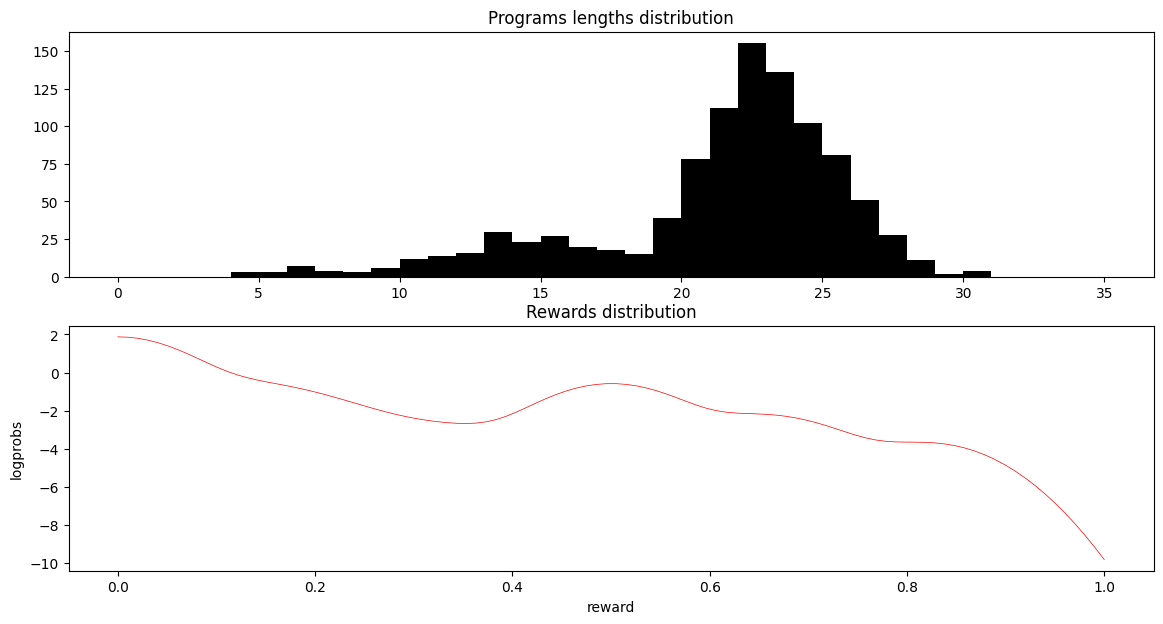

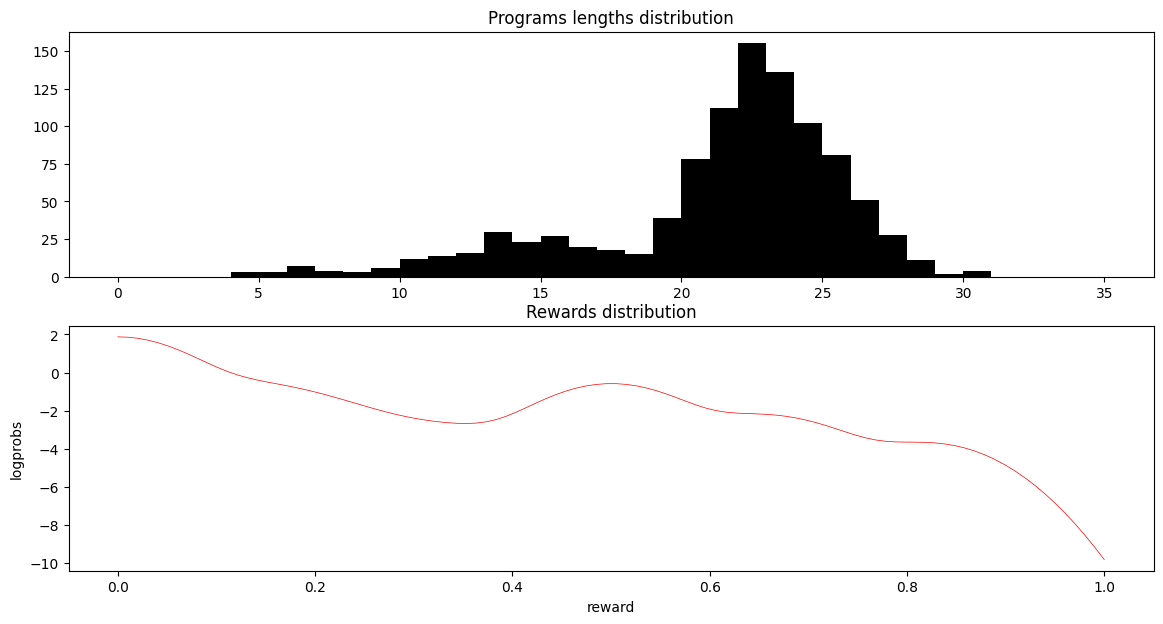

In [27]:
benchmark.dummy_epoch(X, y, run_config)

## Sanity checks

Data


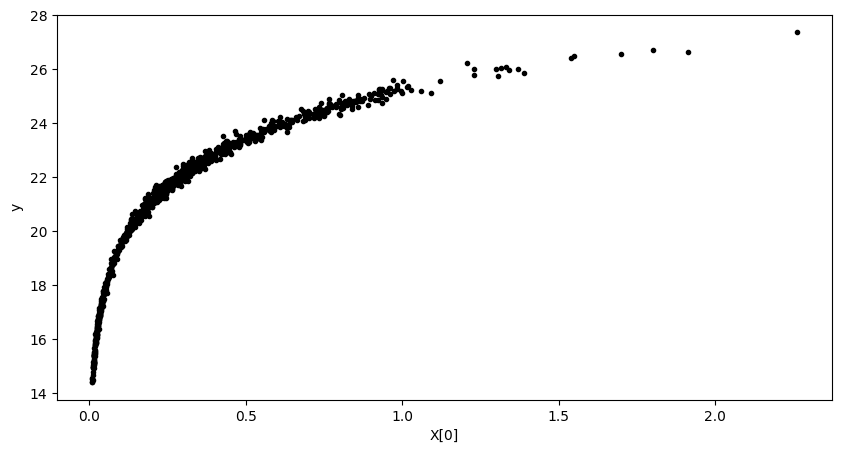

{'mul': 0, 'add': 1, 'sub': 2, 'div': 3, 'inv': 4, 'n2': 5, 'sqrt': 6, '1': 7, 'H0': 8, 'Omega': 9, 'x': 10}
-------------------------- Library -------------------------
[mul add sub div inv n2 sqrt 1 H0 Omega x sqrtH dummy -]
--------------------------- Prior --------------------------
PriorCollection:
- HardLengthPrior (min_length = 4, max_length = 35)
- SoftLengthPrior (length_loc = 6, scale = 5)
- NoUselessInversePrior (['inv', 'n2', 'sqrt'] can not be child of ['inv', 'sqrt', 'n2'])
- PhysicalUnitsPrior
- OccurrencesPrior (tokens ['1'] can be used [4] times max)
-------------------------- Dataset -------------------------
X        : torch.Size([1, 1048]) 
y_target : torch.Size([1048])
-------------------------- Programs ------------------------
[['dummy' '-' '-' ... '-' '-' '-']
 ['dummy' '-' '-' ... '-' '-' '-']
 ['dummy' '-' '-' ... '-' '-' '-']
 ...
 ['dummy' '-' '-' ... '-' '-' '-']
 ['dummy' '-' '-' ... '-' '-' '-']
 ['dummy' '-' '-' ... '-' '-' '-']]

-----------------------

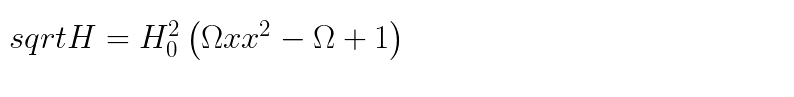

Simplified expression:


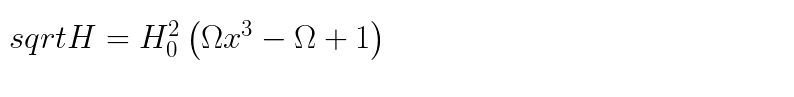

free const opti time = 115.427584 ms


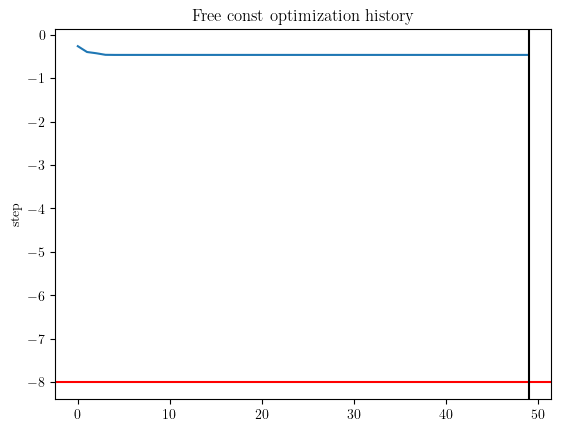

Ideal reward : 0.8191991169744104


In [28]:
target_program = benchmark.sanity_check(X, y, run_config, candidate_wrapper = wrapper_func, target_program_str=target_program_str, expected_ideal_reward=0.80)

## Run

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 4 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 24 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 42 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 52 -> r = 0
  war

Unable to draw one or more prog curve on monitoring plot.
=========== Epoch 00000 ===========
-> Time 2.24 s

Overall best  at R=0.851815
-> Raw expression : 
           1            
────────────────────────
                  2     
⎛       1        ⎞    x 
⎜────────────────⎟  + ──
⎜             0.5⎟    H₀
⎜⎛   ⎛     Ω⎞⎞   ⎟      
⎜⎜H₀⋅⎜-Ω + ─⎟⎟   ⎟      
⎝⎝   ⎝     x⎠⎠   ⎠      

Best of epoch at R=0.851815
-> Raw expression : 
           1            
────────────────────────
                  2     
⎛       1        ⎞    x 
⎜────────────────⎟  + ──
⎜             0.5⎟    H₀
⎜⎛   ⎛     Ω⎞⎞   ⎟      
⎜⎜H₀⋅⎜-Ω + ─⎟⎟   ⎟      
⎝⎝   ⎝     x⎠⎠   ⎠      




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 3 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 6 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 27 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 59 -> r = 0
  warn

Unable to draw one or more prog curve on monitoring plot.
=========== Epoch 00001 ===========
-> Time 39.61 s

Overall best  at R=0.853231
-> Raw expression : 
                  0.5
   ⎛  ⎛      0.5⎞⎞   
H₀⋅⎝Ω⋅⎝-Ω + x   ⎠⎠   

Best of epoch at R=0.853231
-> Raw expression : 
                  0.5
   ⎛  ⎛      0.5⎞⎞   
H₀⋅⎝Ω⋅⎝-Ω + x   ⎠⎠   




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 10 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 17 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 32 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 74 -> r = 0
  wa

Unable to draw one or more prog curve on monitoring plot.
=========== Epoch 00002 ===========
-> Time 42.51 s

Overall best  at R=0.893573
-> Raw expression : 
              2       
       0.5 ⎛1⎞   1    
(Ω + x)   ⋅⎜─⎟ ⋅────⋅1
           ⎝1⎠  ⎛x ⎞  
                ⎜──⎟  
                ⎝H₀⎠  

Best of epoch at R=0.893573
-> Raw expression : 
              2       
       0.5 ⎛1⎞   1    
(Ω + x)   ⋅⎜─⎟ ⋅────⋅1
           ⎝1⎠  ⎛x ⎞  
                ⎜──⎟  
                ⎝H₀⎠  




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 8 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 29 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 43 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 62 -> r = 0
  war

Unable to draw one or more prog curve on monitoring plot.
=========== Epoch 00003 ===========
-> Time 40.65 s

Overall best  at R=0.933519
-> Raw expression : 
                   0.5       
  ⎛            0.5⎞      1   
1⋅⎝((-Ω + x)⋅1)   ⎠   ⋅──────
                       ⎛H₀⋅Ω⎞
                       ⎜────⎟
                       ⎜  2 ⎟
                       ⎝H₀  ⎠

Best of epoch at R=0.933519
-> Raw expression : 
                   0.5       
  ⎛            0.5⎞      1   
1⋅⎝((-Ω + x)⋅1)   ⎠   ⋅──────
                       ⎛H₀⋅Ω⎞
                       ⎜────⎟
                       ⎜  2 ⎟
                       ⎝H₀  ⎠




/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 27 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 42 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 90 -> r = 0
  warnings.warn("Unable to optimize.py free constants of prog %i -> r = 0"%(i))
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:118: UserWarning: Unable to optimize.py free constants of prog 108 -> r = 0
  w

Unable to draw one or more prog curve on monitoring plot.
=========== Epoch 00004 ===========
-> Time 51.89 s

Overall best  at R=0.933519
-> Raw expression : 
                   0.5       
  ⎛            0.5⎞      1   
1⋅⎝((-Ω + x)⋅1)   ⎠   ⋅──────
                       ⎛H₀⋅Ω⎞
                       ⎜────⎟
                       ⎜  2 ⎟
                       ⎝H₀  ⎠

Best of epoch at R=0.848560
-> Raw expression : 
                     0.5
  ⎛        H₀       ⎞   
Ω⋅⎜─────────────────⎟   
  ⎜⎛       1       ⎞⎟   
  ⎜⎜───────────────⎟⎟   
  ⎜⎜⎛H₀⋅(-Ω + x⋅1)⎞⎟⎟   
  ⎜⎜⎜─────────────⎟⎟⎟   
  ⎝⎝⎝      1      ⎠⎠⎠   




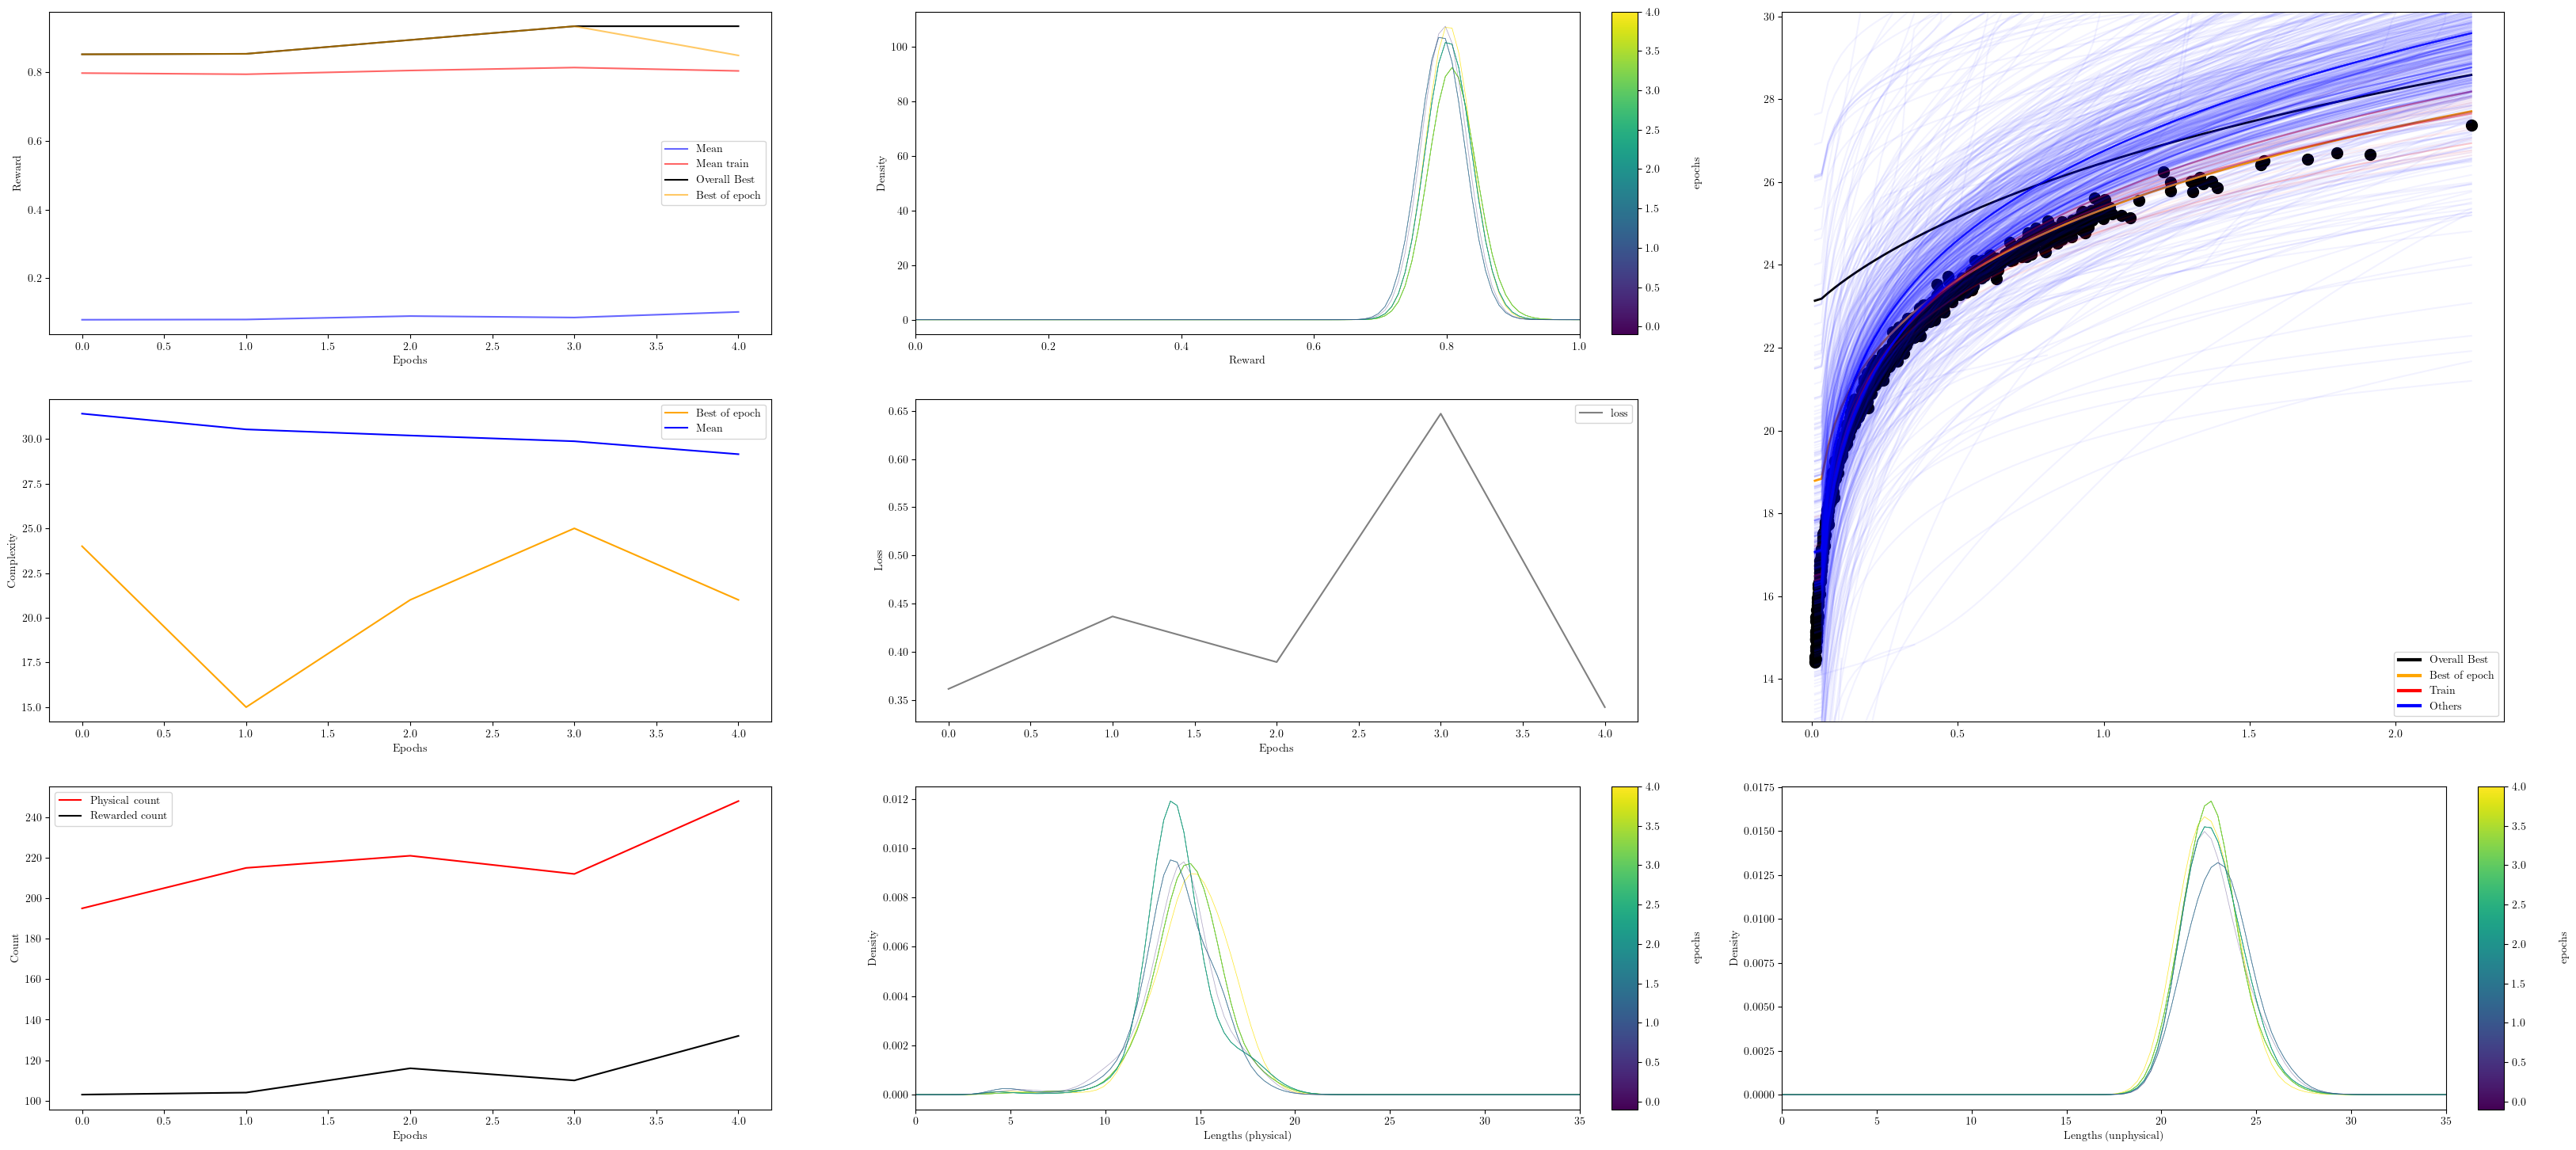

In [29]:
rewards, candidates = physo.fit(X, y, run_config, candidate_wrapper = wrapper_func)

## Results

### Run plot

Unable to draw one or more prog curve on monitoring plot.


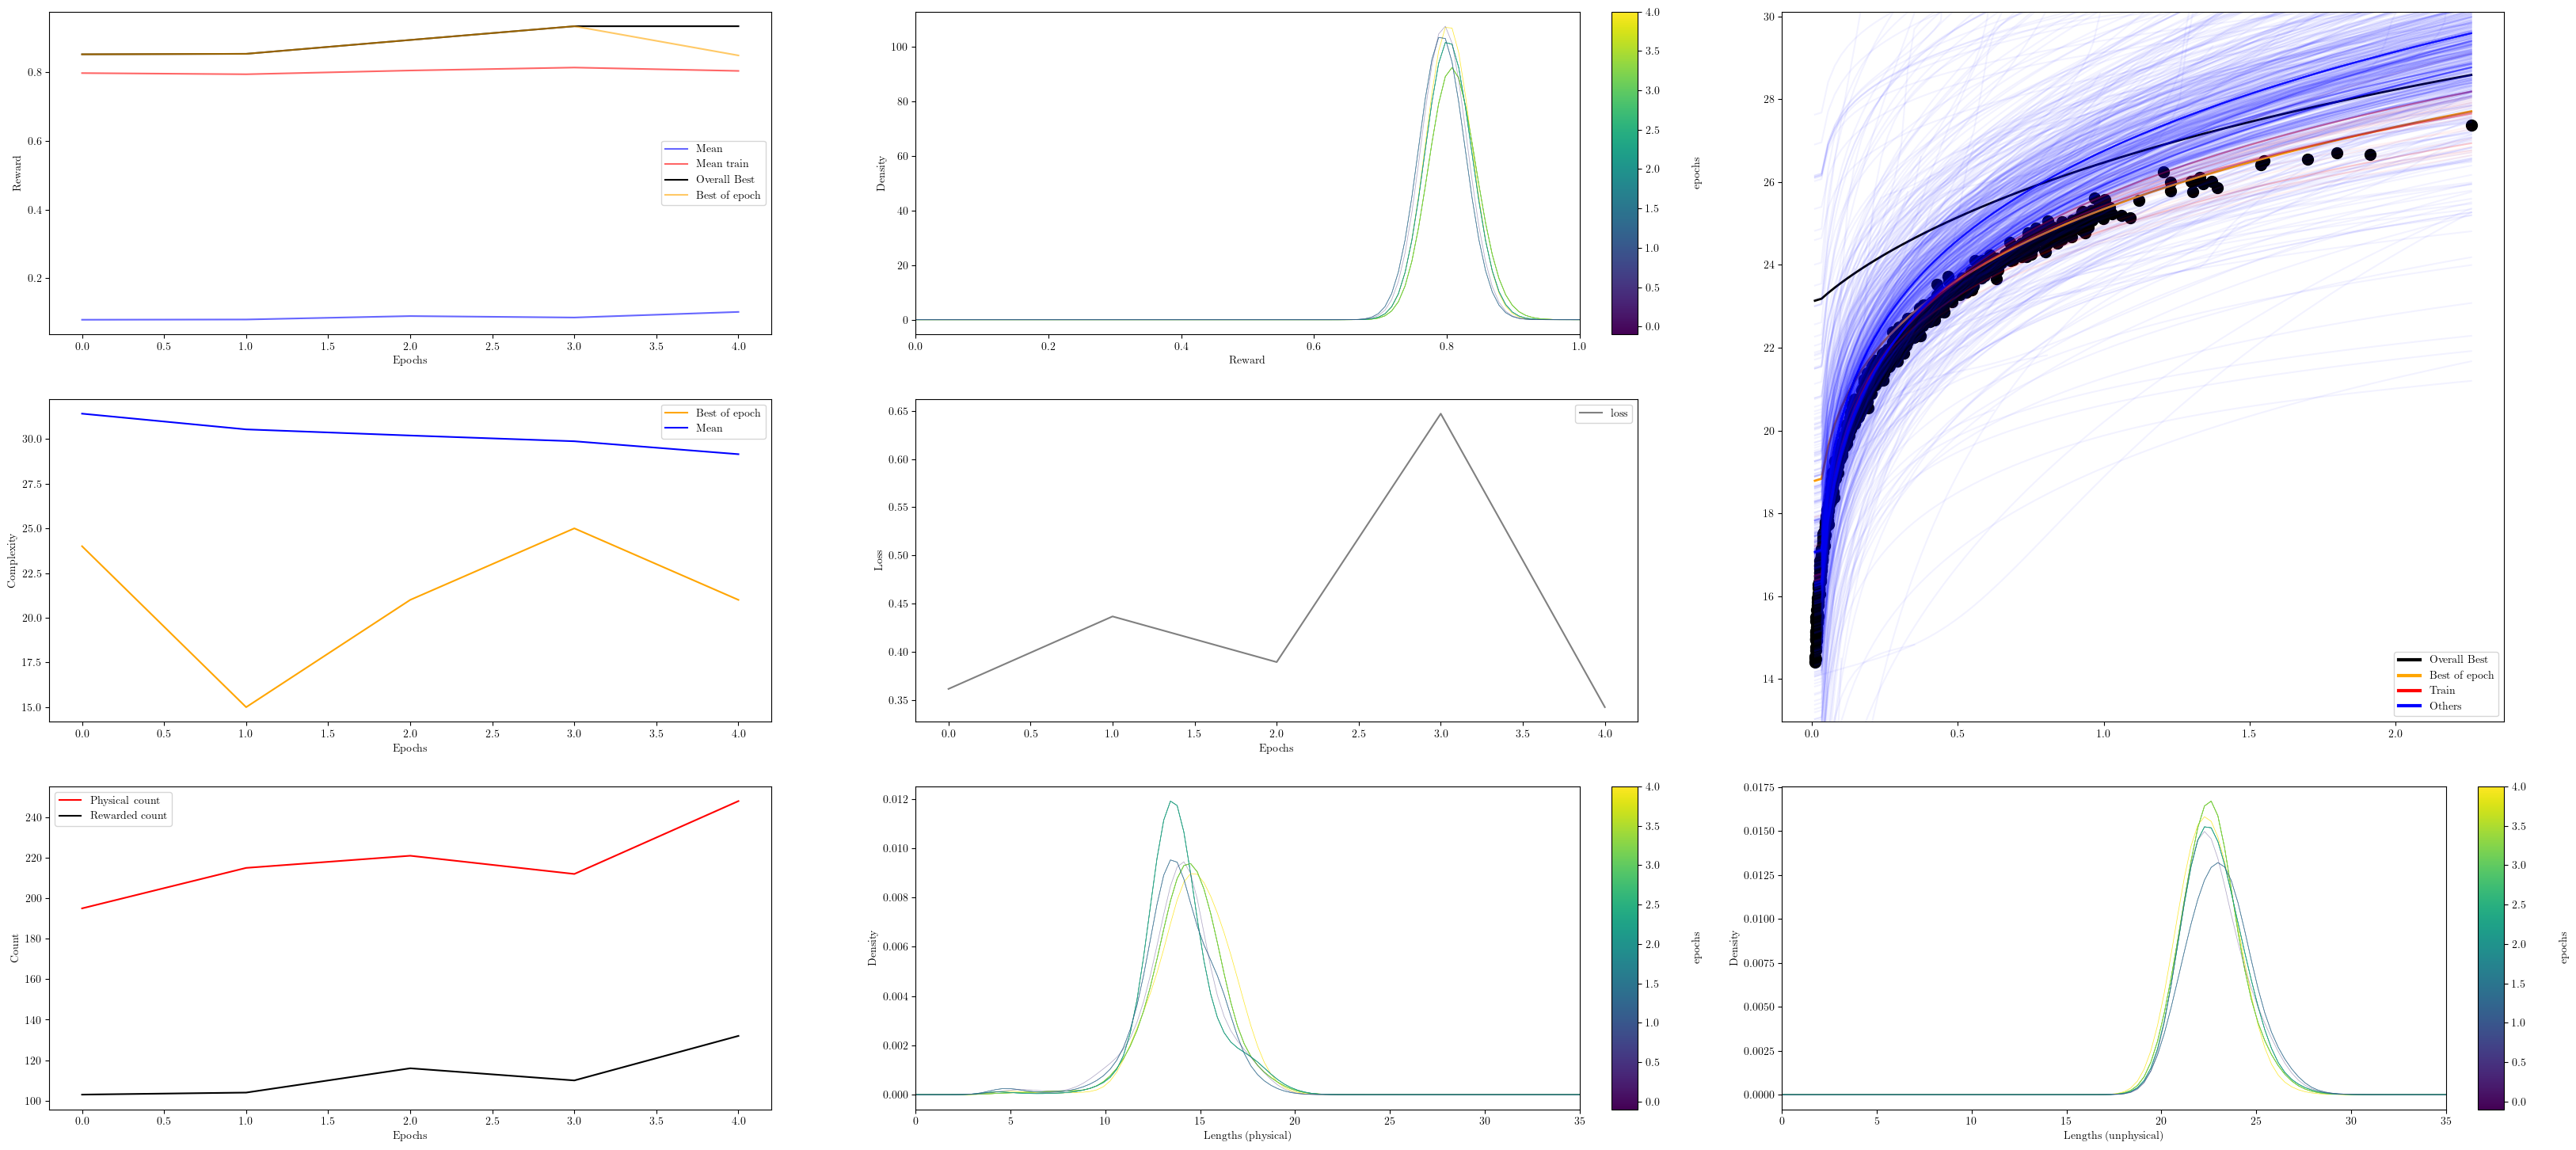

In [30]:
run_visualiser.make_visualisation()

### Pareto Front

In [31]:
def plot_pareto_front(run_logger,
                      do_simplify                   = True,
                      show_superparent_at_beginning = True,
                      eq_text_size                  = 12,
                      delta_xlim                    = [0, 5 ],
                      delta_ylim                    = [0, 15],
                      frac_delta_equ                = [0.03, 0.03],
                      figsize                       = (20, 10),
                     ):

    pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

    pareto_front_rmse = np.log(pareto_front_rmse)
    # Fig params
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    # enables new_dummy_symbol = "\square"
    plt.rc('text.latex', preamble=r'\usepackage{amssymb} \usepackage{xcolor}')
    plt.rc('font', size=32)

    # Fig
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'r-')
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'ro')

    # Limits
    xmin = pareto_front_complexities.min() + delta_xlim[0]
    xmax = pareto_front_complexities.max() + delta_xlim[1]
    ymin = pareto_front_rmse.min() + delta_ylim[0]
    ymax = pareto_front_rmse.max() + delta_ylim[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Axes labels
    ax.set_xlabel("Expression complexity")
    ax.set_ylabel("log(RMSE)")


    for i_prog in range (len(pareto_front_programs)):
        prog = pareto_front_programs[i_prog]

        text_pos  = [pareto_front_complexities[i_prog] + frac_delta_equ[0]*(xmax-xmin), 
                     pareto_front_rmse[i_prog]         + frac_delta_equ[1]*(ymax-ymin)]
        # Getting latex expr
        latex_str = prog.get_infix_latex(do_simplify = do_simplify)
        # Adding "superparent =" before program to make it pretty
        if show_superparent_at_beginning:
            latex_str = prog.library.superparent.name + ' =' + latex_str


        ax.text(text_pos[0], text_pos[1], f'${latex_str}$', size = eq_text_size)

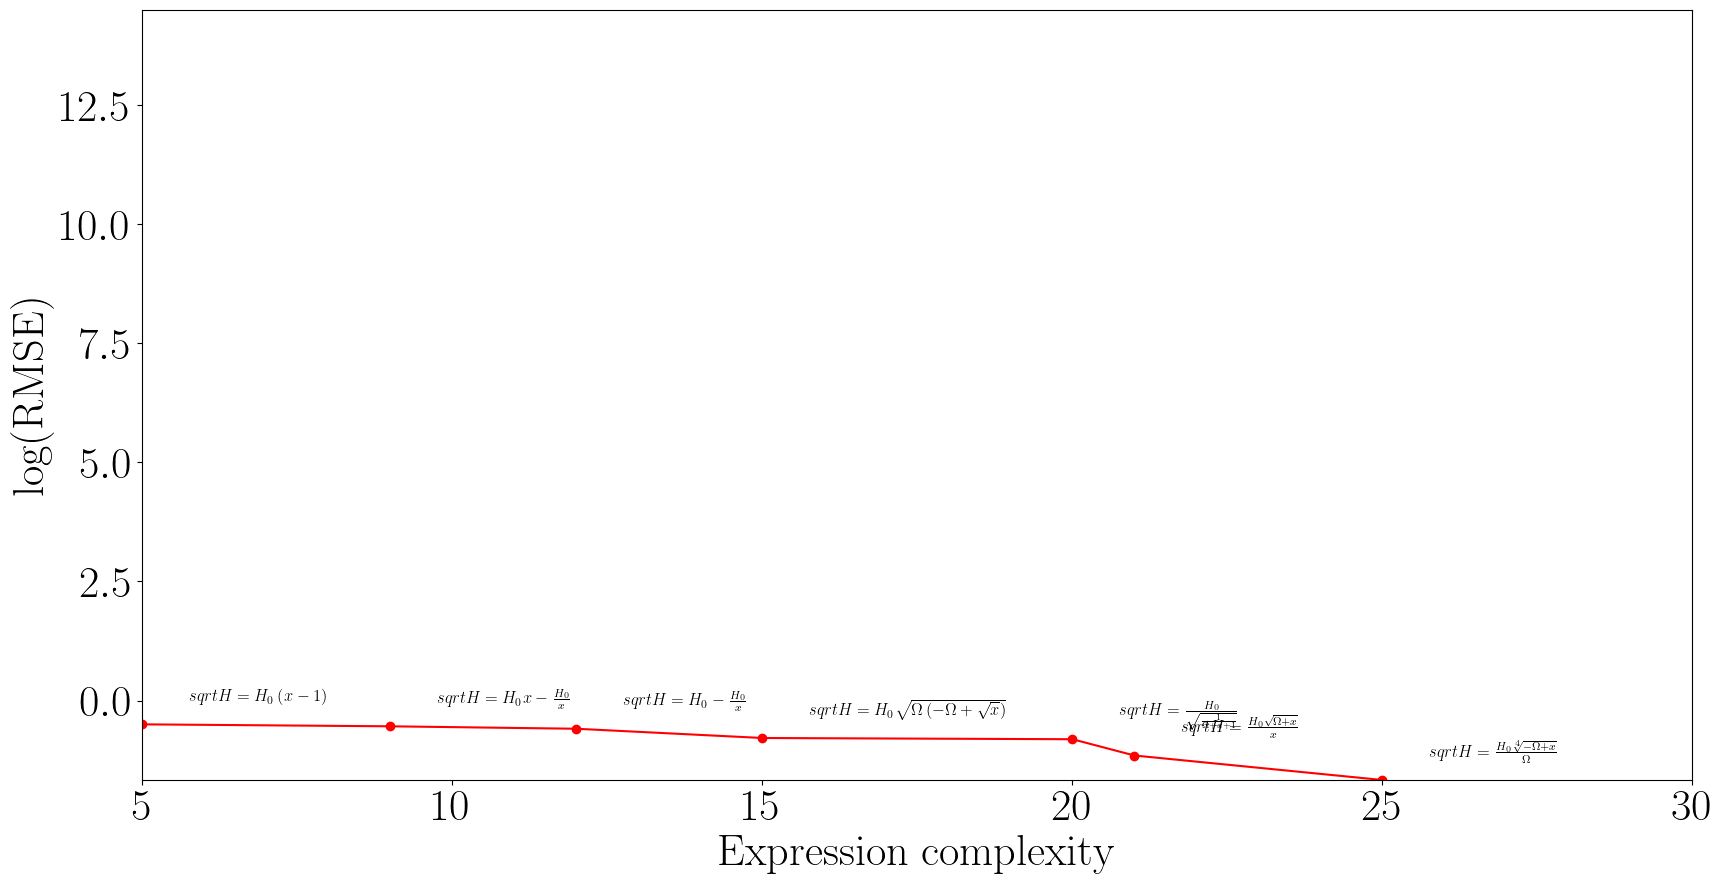

In [32]:
plot_pareto_front(run_logger)


In [33]:
pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()


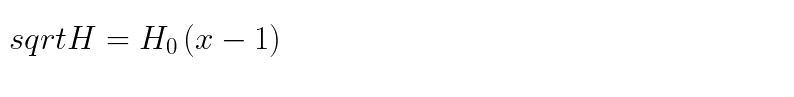

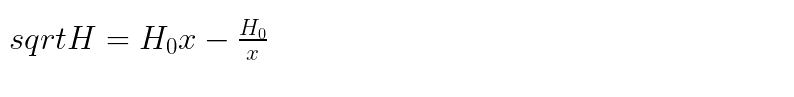

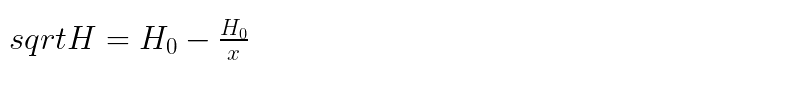

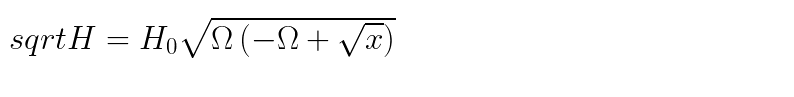

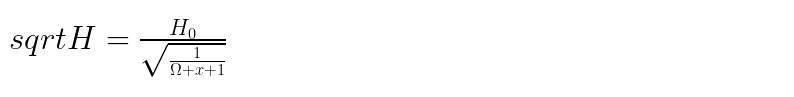

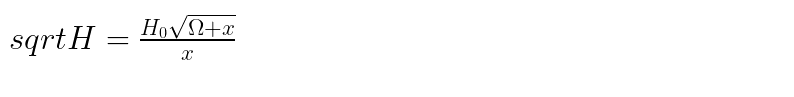

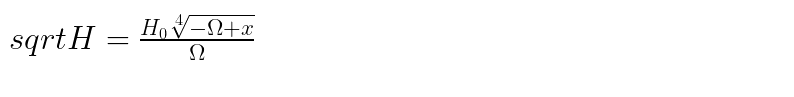

In [34]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)

### Symbolic equivalence

In [35]:
best_prog_sympy   = candidates[-1] .get_infix_sympy(do_simplify=True)
target_prog_sympy = target_program .get_infix_sympy(do_simplify=True)

In [36]:
target_prog_sympy

H0**2*(Omega*x**3 - Omega + 1)

In [37]:
best_prog_sympy

H0*(-Omega + x)**(1/4)/Omega

In [38]:
target_prog_sympy == best_prog_sympy

False

In [39]:
hall_of_fame = run_logger.hall_of_fame

In [40]:
for i in range(len(hall_of_fame)):
    print(hall_of_fame[i].get_infix_sympy(do_simplify=False))

1/((1/((H0*(-Omega + Omega/x))**0.5))**2 + x/H0)
H0*(Omega*(-Omega + x**0.5))**0.5
(Omega + x)**0.5*(1/1)**2*1/(x/H0)
1*((-Omega + x*1)**0.5)**0.5/(H0*Omega/(H0**2))


In [41]:
eq = hall_of_fame[i].get_infix_sympy(do_simplify=True)

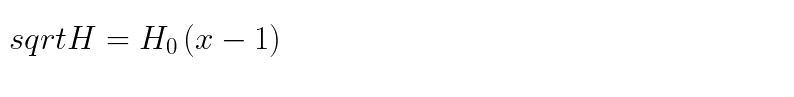

g tensor(26.7175, dtype=torch.float64)
m tensor(1., dtype=torch.float64)


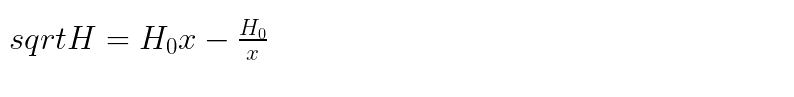

g tensor(14.0585, dtype=torch.float64)
m tensor(1., dtype=torch.float64)


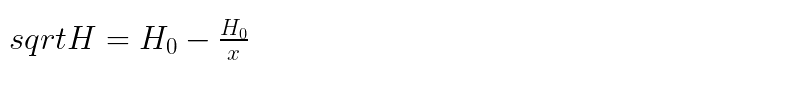

g tensor(29.8815, dtype=torch.float64)
m tensor(1., dtype=torch.float64)


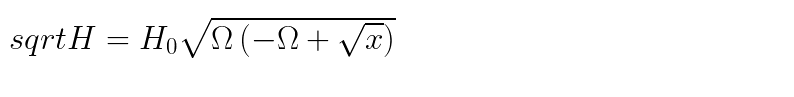

g tensor(10.0387, dtype=torch.float64)
m tensor(1.0050, dtype=torch.float64)


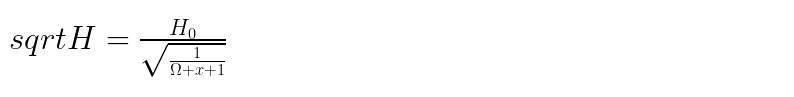

g tensor(7.8788, dtype=torch.float64)
m tensor(-2.0091, dtype=torch.float64)


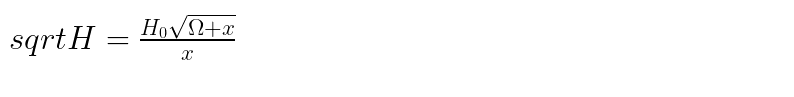

g tensor(9.4742, dtype=torch.float64)
m tensor(-1.0101, dtype=torch.float64)


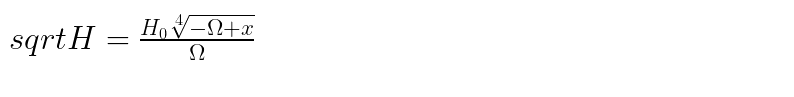

g tensor(4.8315, dtype=torch.float64)
m tensor(1.0101, dtype=torch.float64)


In [42]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)
    print("g", prog.free_const_values[0])
    print("m", prog.free_const_values[1])